In [1]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")


In [15]:
from langchain_openai import AzureChatOpenAI
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities.sql_database import SQLDatabase
from langchain import hub
from langchain.tools import BaseTool
from dotenv import load_dotenv
import os

load_dotenv()


True

In [3]:
llm = AzureChatOpenAI(
    azure_deployment=os.environ.get("azure_openai_deployment", ""), model="gpt-4o-mini"
)
db = SQLDatabase.from_uri("sqlite:///data/library_database.sqlite")


In [4]:
from typing_extensions import Annotated,TypedDict

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [5]:
write_query({"question":"Create a new row in books table"})

{'query': "INSERT INTO books (isbn, book_title, category, rental_price, author, publisher) VALUES ('978-0-12345678-9', 'New Book Title', 'New Category', 8.0, 'New Author', 'New Publisher')"}

In [7]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [19]:
query = write_query({"question":"Check if harry potter is available and currently not rented"})


In [20]:
query

{'query': "SELECT b.book_title, b.isbn FROM books b LEFT JOIN rentals r ON b.isbn = r.isbn WHERE b.book_title LIKE '%Harry Potter%' AND r.return_date IS NULL LIMIT 10;"}

In [17]:
execute_query({"query":query["query"]})

{'result': '[("Harry Potter and the Sorcerer\'s Stone", \'978-0-679-76489-8\')]'}

In [9]:
query

{'query': 'SELECT b.book_title FROM books b JOIN rentals r ON b.isbn = r.isbn WHERE r.return_date IS NULL LIMIT 10'}

In [10]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [11]:
from langgraph.graph import START, StateGraph
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])
config = {"configurable": {"thread_id": "1"}}

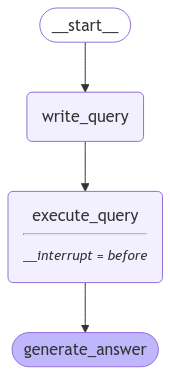

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
for step in graph.stream(
    {"question": "List the name of the books which are rented and not returned"},
    config,
    stream_mode="updates",
):
    print(step)

{'write_query': {'query': 'SELECT b.book_title FROM books b JOIN rentals r ON b.isbn = r.isbn WHERE r.return_date IS NULL LIMIT 10;'}}
{'__interrupt__': ()}


In [14]:
for step in graph.stream(
    {"question": "Add data to rentals table to rent harry potter"},
     config,
      stream_mode="updates"
):
    print(step)


{'write_query': {'query': "SELECT isbn, book_title, author FROM books WHERE book_title LIKE '%Harry Potter%' LIMIT 10;"}}
{'__interrupt__': ()}


In [30]:
query = "SELECT * from books where lower(book_title) like '%animal%' AND lower(category) like '%%';"

In [31]:
query

"SELECT * from books where lower(book_title) like '%animal%' AND lower(category) like '%%';"

In [32]:

execute_query({"query":query})

{'result': "[('978-0-330-25864-8', 'Animal Farm', 'Classic', 5.5, 'George Orwell', 'Penguin Books')]"}